In [1]:
from pylab import *
from scipy.optimize import curve_fit
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import seaborn as sns

def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )


def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)


def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)


def plot_histograms(data_array, nbins, proportion1):
    if data_array is None:
        data = concatenate((normal(0,.015,50000),normal(0.05,.03,5000)))
    else:
        data = data_array
        
    sns.set()
    q = round(np.quantile(data, proportion1),3)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), gridspec_kw={'wspace':0.35})
    ax[0].hist(data, nbins, alpha=0.7, color='grey')
    ax[0].set_title('Frequency histogram')
    ax[0].set_ylabel('Count')

    ax[1].hist(data, nbins, alpha=0.7, cumulative=True, density=True, color='grey')
    ax[1].set_title('Cumulative fraction of pixels intensities')
    ax[1].set_ylabel('Cumulative fraction')
    ax[1].text(y=0.5, x=data.min(), s=f'{proportion1} of pixels \nare < {q}', fontsize=10)
    ax[1].text(y=proportion1+0.015, x=q+0.01, s=f'{round(1-proportion1,3)} of pixels \nare > {q}', fontsize=10);
    ax[1].axhline(proportion1, ls='--', color='black', alpha=0.5)

    for i in range(2):
        ax[i].axvline(q, ls='--',color='navy', alpha=0.5)
        ax[i].text(y=0, x=q, s=str(q), fontsize=10, color='navy');
        ax[i].set_xlabel('Pixel intensity')
        ax[i].text(y=0, x=q, s=str(q), fontsize=10, color='navy')
    plt.show()
    
    return data
    
def plot_GMM(data, expected_paramaters_gaussian1, expected_parameters_gaussian2):
    y,x,_=hist(data,nbins,alpha=.3,label='real data', color='grey')
    x=(x[1:]+x[:-1])/2 # for len(x)==len(y)
    expected=tuple(expected_parameters_gaussian1.values()) + tuple(expected_parameters_gaussian2.values())
    params,cov,info,mesg,ier =curve_fit(bimodal,x,y,expected,full_output=True)
    sigma=sqrt(diag(cov))
    ss_res = np.dot(info['fvec'], info['fvec'])
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    plot(x,bimodal(x,*params),color='teal',lw=2,alpha=0.5,label='model (gaussian1 + gaussian2)')
    legend()
    plt.title(f'Best fit GMM (R^2 = {round(r2,3)})')
    plt.ylabel('Count')
    plt.xlabel('Pixel intensity')
    plt.show()
    
    return {'params':params, 'info':info, 'y':y}

def plot_individual_gaussians(data, params, proportion1, nbins):
    CI_dict = {'68':1, '95':2, '99':3}
    CI = input('Do you want to use a 68%, 95%, or 99% confidence interval? (type the number and press enter) ')    
    try:
        std = CI_dict[CI]
    except KeyError:
        print(f'You entered {CI}, try again and enter one of 68, 95, or 99')
    
    xrange = np.linspace(data.min(), data.max(), nbins)
    gaussian1 = gaussian(xrange, params[0], params[1])
    g1_upper = params[0]+(std*params[1])
    g1_lower = params[0]-(std*params[1])
    gaussian2 = gaussian(xrange, params[3], params[4])
    g2_upper = params[3]+(std*params[4])
    g2_lower = params[3]-(std*params[4])
    
    curve_dict = {'left':g1_upper, 'right':g2_lower, 'both':[g1_upper, g2_lower]}
    curve = input('Which distribution do you want to use to decide a cut-off? (type left, right, or both and press enter) ')
    try:
        cutoff = curve_dict[curve]
    except KeyError:
        print(f'You entered {curve}, try again and enter left, right, or both')
    cutoff_color = 'darkred' if curve == 'right' else 'navy'
    
    plt.plot(xrange, gaussian1, color='navy',alpha=0.5, ls='--',linewidth=1)
    plt.plot(xrange, gaussian1*proportion1, color='navy',alpha=0.7, linewidth=2)
    plt.plot(xrange, gaussian2, color='darkred',alpha=0.5, ls='--',linewidth=1)
    plt.plot(xrange, gaussian2*(1-proportion1), color='darkred',alpha=0.7, linewidth=2)
    ylim = plt.ylim()[1]
    
    if curve == 'both':
        lower = cutoff[0] if cutoff[0] < cutoff[1] else cutoff[1]
        upper = cutoff[0] if cutoff[0] > cutoff[1] else cutoff[1]
        lower = round(lower,3)
        upper = round(upper, 3)
        plt.axvspan(lower, upper, color='magenta', alpha=0.15)
        plt.text(x=lower, y=ylim, s=f'Excluded area ({lower} to {upper})', color='magenta', fontsize=12)
    else:
        cutoff = round(cutoff,3)
        plt.axvline(cutoff, color='magenta', alpha=0.5, linewidth=2)
        plt.text(x=cutoff, y=ylim, s=f'{cutoff} cutoff', color='magenta', fontsize=12)
    plt.hist(data, bins=nbins, density=True, color='grey',alpha=0.5)
    plt.ylabel('Arbitrary Units')
    plt.xlabel('Pixel intensity')
    plt.title('Probability density function (area under curve = 1 for unscaled)', y=1.05, fontsize=15)
    plt.legend(['gaussian1 (unscaled)', f'gaussian1 (unscaled x {proportion1})', 
                'gaussian2 (unscaled)', f'gaussian2 (unscaled x {round(1-proportion1,3)})'])
    
    plt.show();
    
    print(f'Your cut-off value is {cutoff}')
    
    return {'cutoff':round(cutoff, 3),
            'all confidence intervals':{'left_lower':g1_lower, 'left_upper':g1_upper, 'right_lower':g2_lower, 'right_upper':g2_upper}
           }

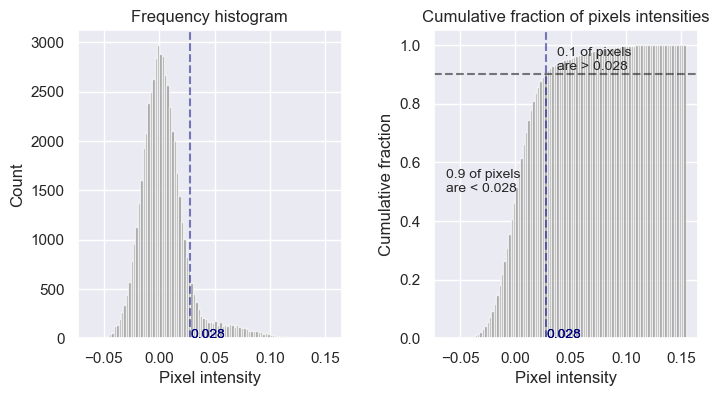

In [2]:
data_array = None
proportion1 = 0.9
nbins=100
data_used = plot_histograms(data_array, nbins, proportion1) #if data_array is initially None (and example data is used), then this data is returned and saved as "data_array"

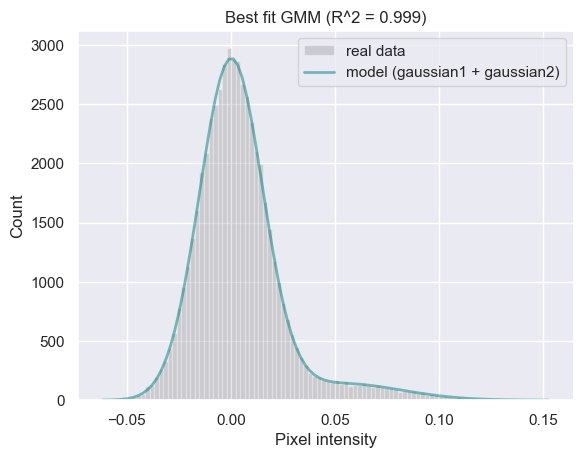

In [4]:
expected_parameters_gaussian1 = {'mean':0, 'std':0.02, 'height':3000}
expected_parameters_gaussian2 = {'mean':0.05, 'std':0.02, 'height':200}
output = plot_GMM(data_used, expected_parameters_gaussian1, expected_parameters_gaussian2)

In [6]:
output['params'][2]

2863.613341684537

Do you want to use a 68%, 95%, or 99% confidence interval? (type the number and press enter) 95
Which distribution do you want to use to decide a cut-off? (type left, right, or both and press enter) left


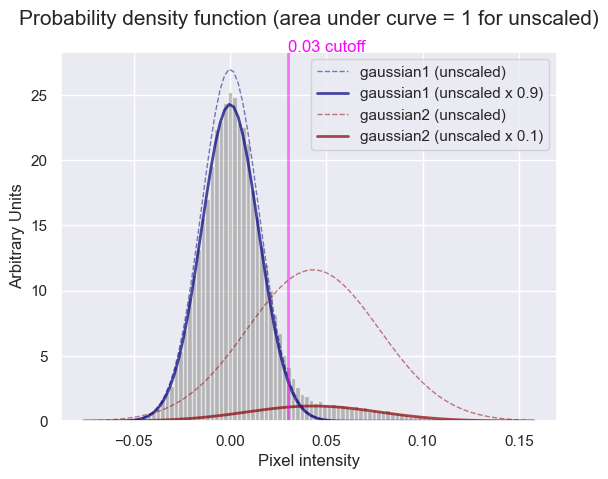

Your cut-off value is 0.03


In [178]:
confidence_intervals = plot_individual_gaussians(data_used, output['params'], proportion1, nbins)